In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet, vgg16, vgg19

# 預處理函數對照表
PREPROCESS_FN = {
    'VGG16': vgg16.preprocess_input,
    'VGG19': vgg19.preprocess_input,
    'ResNet50': resnet.preprocess_input,
    'ResNet101': resnet.preprocess_input,
    'ResNet152': resnet.preprocess_input,
}

2026-01-03 22:07:18.685588: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 22:07:18.849565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767449238.925554   30139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767449238.946229   30139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-03 22:07:19.117686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
IMG_FOLDER = '/mnt/f/course/computer_vision/final_proj_img/final_proj_img/pic/'
TXT_FOLDER = '/mnt/f/course/computer_vision/txt/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # 降低 batch size 以節省 GPU 記憶體

# 資料增強層
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

I0000 00:00:1767449243.059324   30139 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
def load_dataset_from_name_txt(img_folder, txt_folder):
    filename_list = []
    class_name_list = []
    
    # 1. 讀取 name.txt
    # 格式: "AncestorDinoArt_001.jpg AncestorDinoArt"
    name_txt_path = os.path.join(txt_folder, 'name.txt')
    print(f"Reading name.txt from: {name_txt_path}")
    
    with open(name_txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                filename_list.append(parts[0])      # e.g., AncestorDinoArt_001.jpg
                class_name_list.append(parts[1])    # e.g., AncestorDinoArt (這也是資料夾名稱)
    
    # 2. 建立標籤對照表
    unique_classes = sorted(list(set(class_name_list)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    print(f"Detected {len(unique_classes)} classes.")

    # 3. 讀取 query.txt (注意：這裡假設 query.txt 是 1-based index)
    query_txt_path = os.path.join(txt_folder, 'query.txt')
    with open(query_txt_path, 'r') as f:
        test_indices = set([int(line.strip()) - 1 for line in f])

    # 4. 分裝 Train / Test
    train_paths = []
    train_labels = []
    test_paths = []
    test_labels = []

    missing_count = 0

    for idx, filename in enumerate(filename_list):
        class_name = class_name_list[idx]
        
        # --- [關鍵修正] 路徑加入類別資料夾 ---
        # 舊路徑: pic/AncestorDinoArt_001.jpg (錯誤)
        # 新路徑: pic/AncestorDinoArt/AncestorDinoArt_001.jpg (正確)
        full_path = os.path.join(img_folder, class_name, filename)
        
        label_idx = class_to_idx[class_name]
        
        # 檢查檔案是否存在
        if not os.path.exists(full_path):
            if missing_count < 5: # 只印出前 5 個錯誤以免洗版
                print(f"Warning: File not found: {full_path}")
            missing_count += 1
            continue

        if idx in test_indices:
            test_paths.append(full_path)
            test_labels.append(label_idx)
        else:
            train_paths.append(full_path)
            train_labels.append(label_idx)

    if missing_count > 0:
        print(f"Total missing files: {missing_count}")
    else:
        print("All files found successfully!")

    return (train_paths, train_labels), (test_paths, test_labels), len(unique_classes)

# --- 執行讀取測試 ---
(tr_x, tr_y), (te_x, te_y), num_classes = load_dataset_from_name_txt(IMG_FOLDER, TXT_FOLDER)

print(f"Training Data: {len(tr_x)} images")
print(f"Testing Data: {len(te_x)} images")

# 建立 tf.data Pipeline (基礎預處理，不含模型特定預處理)
def preprocess_base(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    # 將標籤轉換為 one-hot 編碼
    label_onehot = tf.one_hot(label, depth=num_classes)
    return img, label_onehot

# 建立基礎資料集 (不做模型特定預處理，會在模型中處理)
train_paths_ds = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
train_ds_base = train_paths_ds.shuffle(buffer_size=len(tr_x)).map(preprocess_base, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_base = train_ds_base.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_paths_ds = tf.data.Dataset.from_tensor_slices((te_x, te_y))
test_ds_base = test_paths_ds.map(preprocess_base, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_base = test_ds_base.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Ready for ResNet/VGG training!")

Reading name.txt from: /mnt/f/course/computer_vision/txt/name.txt
Detected 50 classes.
Total missing files: 2
Training Data: 6999 images
Testing Data: 2999 images
Ready for ResNet/VGG training!


In [4]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, VGG16, VGG19
from tensorflow.keras import layers, models, Input

In [5]:
def build_model(model_name, fine_tune=False, fine_tune_at=0):
    """
    建構遷移學習模型
    
    Args:
        model_name: 模型名稱
        fine_tune: 是否進行 fine-tuning
        fine_tune_at: 從第幾層開始解凍 (0 = 全部凍結)
    """
    inputs = Input(shape=(224, 224, 3))
    
    # 資料增強 (只在訓練時套用)
    x = data_augmentation(inputs)
    
    # 套用模型特定的預處理
    preprocess_fn = PREPROCESS_FN[model_name]
    x = preprocess_fn(x)
    
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'ResNet152':
        base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # 凍結 base model
    base_model.trainable = False
    
    # 如果要 fine-tune，解凍部分層
    if fine_tune and fine_tune_at > 0:
        base_model.trainable = True
        # 凍結 fine_tune_at 之前的層
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        print(f"Fine-tuning from layer {fine_tune_at}, total layers: {len(base_model.layers)}")
    
    x = base_model(x, training=False)  # training=False 確保 BN 層使用預訓練統計值
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # 增加 dropout 防止過擬合
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model


In [6]:
model_list = ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152']

# Fine-tune 起始層設定 (從這層開始解凍)
FINE_TUNE_LAYERS = {
    'VGG16': 15,      # VGG16 有 19 層，解凍最後 4 層
    'VGG19': 17,      # VGG19 有 22 層，解凍最後 5 層
    'ResNet50': 140,  # ResNet50 有 175 層，解凍最後 35 層
    'ResNet101': 300, # ResNet101 有 333 層，解凍最後 33 層
    'ResNet152': 480, # ResNet152 有 515 層，解凍最後 35 層
}

history_dict = {}
results = {}
EPOCHS_PHASE1 = 20  # 第一階段：只訓練頂層
EPOCHS_PHASE2 = 30  # 第二階段：Fine-tuning

for model_name in model_list:
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # ===== 第一階段：凍結 base model，只訓練頂層 =====
    print(f"\n[Phase 1] Training top layers only (frozen base model)")
    model, base_model = build_model(model_name, fine_tune=False)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_phase1 = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    history1 = model.fit(
        train_ds_base,
        epochs=EPOCHS_PHASE1,
        validation_data=test_ds_base,
        callbacks=callbacks_phase1
    )
    
    # ===== 第二階段：Fine-tuning =====
    print(f"\n[Phase 2] Fine-tuning from layer {FINE_TUNE_LAYERS[model_name]}")
    
    # 解凍部分 base model 層
    base_model.trainable = True
    fine_tune_at = FINE_TUNE_LAYERS[model_name]
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # 使用較低的學習率進行 fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 降低學習率
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_phase2 = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-7
        )
    ]
    
    history2 = model.fit(
        train_ds_base,
        epochs=EPOCHS_PHASE2,
        validation_data=test_ds_base,
        callbacks=callbacks_phase2
    )
    
    # 合併兩階段的 history
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    history_dict[model_name] = combined_history
    
    # 評估模型
    eval_results = model.evaluate(test_ds_base)
    acc = eval_results[1]
    results[model_name] = acc
    print(f"\n{model_name} Final Accuracy: {acc:.4f}")
    
    # 儲存模型
    model.save(f'/home/guan/cuda_test/cv/models/{model_name}_finetuned.keras')
    print(f"Model saved to /home/guan/cuda_test/cv/models/{model_name}_finetuned.keras")
    
    # 釋放記憶體
    del model, base_model
    tf.keras.backend.clear_session()
    
print("\n" + "="*60)
print("Training Complete!")
print("="*60)


Training VGG16

[Phase 1] Training top layers only (frozen base model)
Epoch 1/20


I0000 00:00:1767449269.480793   30242 cuda_dnn.cc:529] Loaded cuDNN version 90300
2026-01-03 22:07:50.316644: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 112ms/step - accuracy: 0.2747 - loss: 10.4013 - val_accuracy: 0.8263 - val_loss: 4.4214 - learning_rate: 0.0010
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - accuracy: 0.6701 - loss: 4.5096 - val_accuracy: 0.8429 - val_loss: 2.7285 - learning_rate: 0.0010
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - accuracy: 0.7407 - loss: 2.9184 - val_accuracy: 0.8823 - val_loss: 1.9220 - learning_rate: 0.0010
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.7436 - loss: 2.2922 - val_accuracy: 0.8803 - val_loss: 1.6586 - learning_rate: 0.0010
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - accuracy: 0.7630 - loss: 2.0286 - val_accuracy: 0.8860 - val_loss: 1.4856 - learning_rate: 0.0010
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.7670 - loss: 1.8892 - val_accuracy: 0.8773 - val_loss: 1.4522 - learning_rate: 0.0010
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - accuracy: 0.7475 - loss

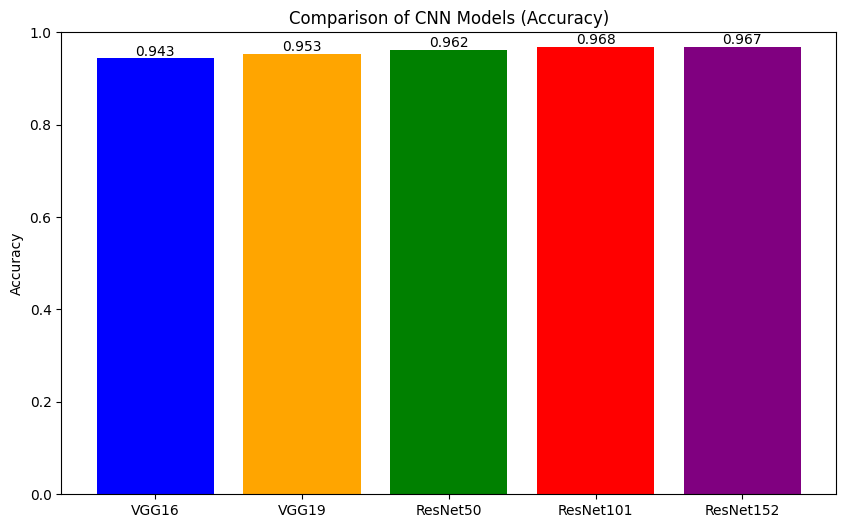

In [7]:
import matplotlib.pyplot as plt
# 繪製 Accuracy 比較長條圖
names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1.0)
plt.title('Comparison of CNN Models (Accuracy)')
plt.ylabel('Accuracy')

# 在長條圖上標示數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()